In [ ]:
# TRAINING A CUSTOM CONVOLUTIONAL NUERALNETWORK FOR SCREENING BREAST CANCER FROM MAMMOGRAM IMAGES
# CONNECTING THE COLAB NOTEBOOK TO GOOGLE DRIVE
# Mounting google drive to get files from there
from google.colab import drive
drive.mount('/content/drive')

print('The current working folder is:')
!pwd


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The current working folder is:
/content


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Breast_Cancer_Screening_dataset.zip'
extract_path = '/content/Extracted/'

import os
os.makedirs(extract_path, exist_ok=True)

# Unzip the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

base_dir = '/content/Extracted/Breast_Cancer_Screening_dataset'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# # Directory with our training classes
train_benign_dir = os.path.join(train_dir, 'benign')
train_malignant_dir = os.path.join(train_dir, 'malignant')
train_benign_without_callback_dir = os.path.join(train_dir, 'benign_without_callback')


# Directory with our validation classes
validation_benign_dir = os.path.join(validation_dir, 'benign')
validation_malignant_dir = os.path.join(validation_dir, 'malignant')
validation_benign_without_callback_dir = os.path.join(validation_dir, 'benign_without_callback')


# Directory with our test classes
test_benign_dir = os.path.join(test_dir, 'benign')
test_malignant_dir = os.path.join(test_dir, 'malignant')
test_benign_without_callback_dir = os.path.join(test_dir, 'benign_without_callback')

In [ ]:
# CHECKING A SAMPLE IMAGE FILE NAMES AND THEIR EXTENSIONS IN THE DATASET...
train_benign_fnames = os.listdir( train_benign_dir )
train_malignant_fnames = os.listdir( train_malignant_dir )
train_benign_without_callback_fnames = os.listdir( train_benign_without_callback_dir )

# CHECKING THE EXTENIONS OF IMAGE FILES IN EACH DIRECTORY
print( train_benign_fnames[:10])
print(train_malignant_fnames[:10])
print(train_benign_without_callback_fnames[:10])


['5889.jpg', '3354.jpg', '4444.jpg', '4748.jpg', '8361.jpg', '6472.jpg', '9074.jpg', '3554.jpg', '9228.jpg', '5841.jpg']
['7678.jpg', '3363.jpg', '3065.jpg', '4217.jpg', '3237.jpg', '9340.jpg', '4387.jpg', '4207.jpg', '3771.jpg', '4660.jpg']
['1562.jpg', '5297.jpg', '7110.jpg', '8089.jpg', '2818.jpg', '3394.jpg', '3041.jpg', '3639.jpg', '6741.jpg', '2936.jpg']


In [ ]:
# ANALYSING THE STATISTIS OF THE TRAINING DATA
print('---------------------- TRAINING IMAGE STATISTICS------------\n')
print('Total training Benign images :', len(os.listdir( train_benign_dir   ) ))
print('Total training Malignant images :', len(os.listdir( train_malignant_dir  ) ))
print('Total training Benign without callback images :', len(os.listdir(  train_benign_without_callback_dir  ) ))


print('\n---------------------- VALIDATION IMAGE STATISTICS-------------\n')
print('Total validation Benign images :', len(os.listdir( validation_benign_dir ) ))
print('Total validation Malignant images :', len(os.listdir( validation_malignant_dir ) ))
print('Total validation Benign without callback images :', len(os.listdir( validation_benign_without_callback_dir ) ))


print('\n---------------------- TEST IMAGE STATISTICS--------------------\n')

print('Total test Benign images :', len(os.listdir( test_benign_dir ) ))
print('Total test Malignant images :', len(os.listdir( test_malignant_dir ) ))
print('Total test Benign without callback images :', len(os.listdir( test_benign_without_callback_dir ) ))


---------------------- TRAINING IMAGE STATISTICS------------

Total training Benign images : 1000
Total training Malignant images : 1000
Total training Benign without callback images : 600

---------------------- VALIDATION IMAGE STATISTICS-------------

Total validation Benign images : 400
Total validation Malignant images : 400
Total validation Benign without callback images : 56

---------------------- TEST IMAGE STATISTICS--------------------

Total test Benign images : 29
Total test Malignant images : 52
Total test Benign without callback images : 30


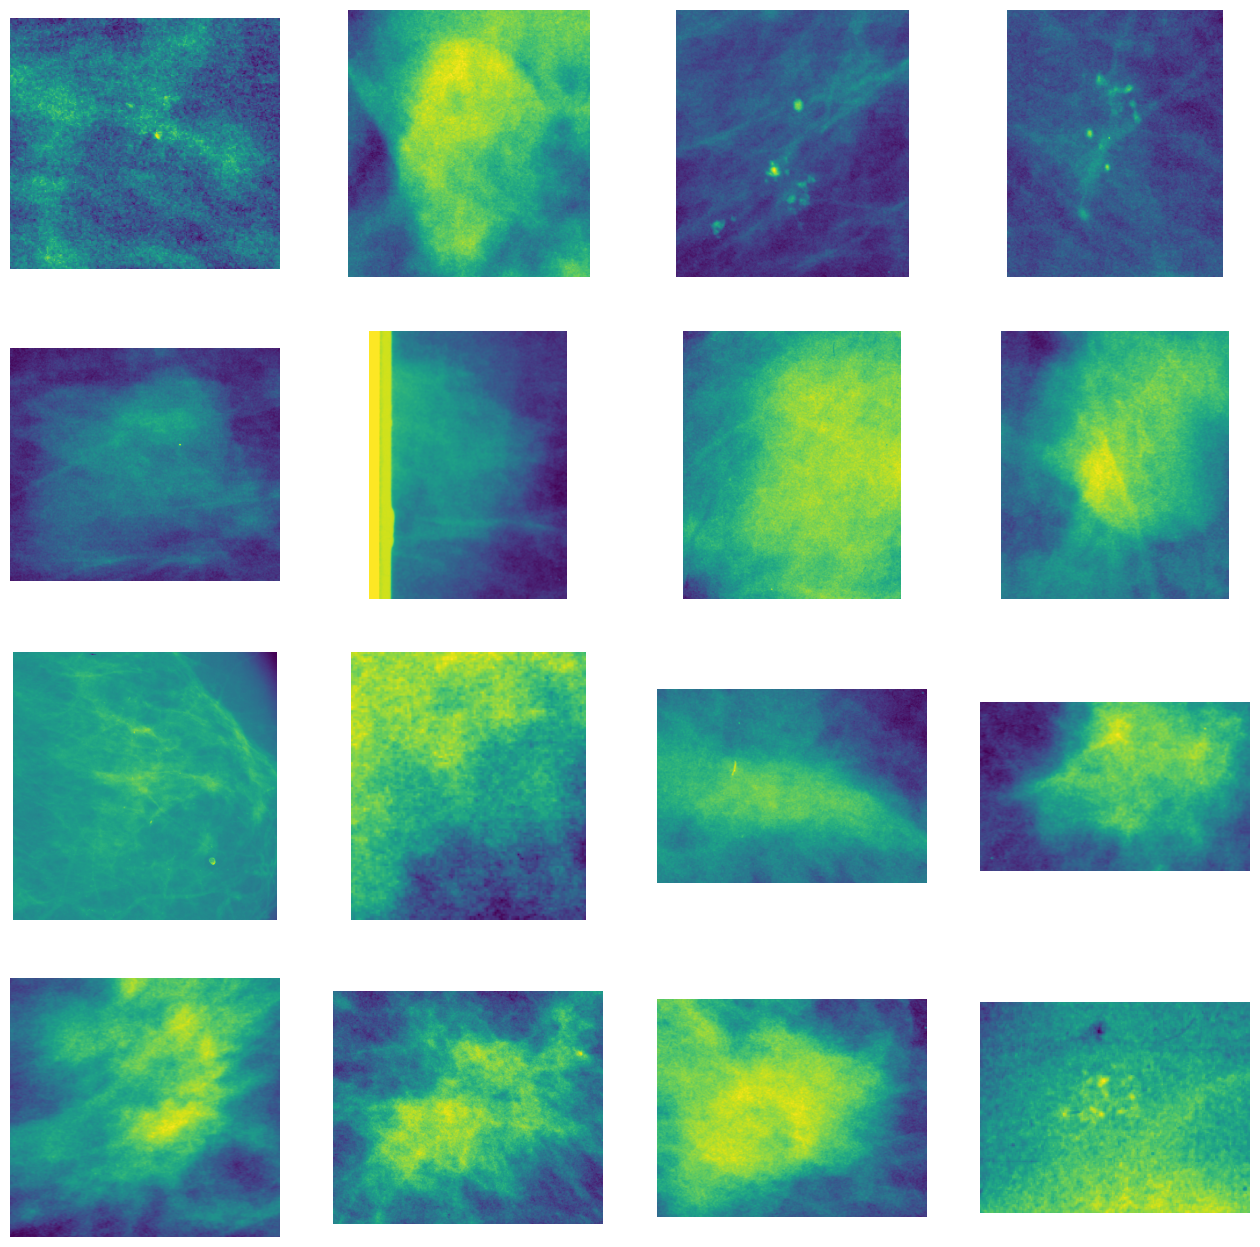

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# VISUALISING SOME IMAGE DATA BEFORE USING IT TO TRAIN THE MODEL(FEATURE EXTRACTOR)
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8

next_benign_pix = [os.path.join(train_benign_dir, fname)
                for fname in train_benign_fnames[ pic_index-8:pic_index]
               ]

next_malignant_pix = [os.path.join(train_malignant_dir, fname)
                for fname in train_malignant_fnames[ pic_index-8:pic_index]
               ]


for i, img_path in enumerate(next_benign_pix + next_malignant_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

#laying out the structure / layers of the  feature extractor
model = tf.keras.models.Sequential([
    #Note the input shape is the desired size of the image 224x224 with 3 bytes color
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (224, 224, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(1024, (3,3), padding='same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # preventing the problem of overfitting using the Dropout layer
    tf.keras.layers.Dropout(0.4),
    # Flatten the results to feed into a Dense Nueral Network
    tf.keras.layers.Flatten(),
    # Fully connected layer of 512 neurons.
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(3, activation="softmax") # categorical activation output
    # tf.keras.layers.Dense(1, activation = 'sigmoid'),

])

# Higher Dropout helps in a way that The neurons can't rely on one input because it might be dropped out at
# random. This reduces bias due to over-relying on one input, bias is a major cause of overfitting.Neurons will
# edundant details  of inputs.

In [ ]:
# GETTING INFORMATION ABOUT THE SUMMARY OF THE MODEL
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [ ]:
# DATA AUGUMENTATION USING KERAS
# All images will be rescaled by 1./255 after going through the image Generator
# And also performing Data augumentation to enhance the capacity of the dataset.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preparing the train image generator
train_datagen = ImageDataGenerator(
     rescale = 1.0/255,
    #  rotation_range = 40,
     width_shift_range = 0.1,
     height_shift_range = 0.1,
    #  shear_range = 0.1,
    #  zoom_range = 0.1,
    #  horizontal_flip = True,
    #  fill_mode = 'nearest'
)

# Preparing the validation image generator with augmentation
validation_datagen  = ImageDataGenerator(
                                      rescale = 1.0/255,
                                    # rotation_range = 40,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    # shear_range = 0.1,
                                    # zoom_range = 0.1,
                                    # horizontal_flip = True,
                                    # fill_mode = 'nearest'
                          )

# For confusion matrix analysis test data generator is defined as follows.
test_datagen = ImageDataGenerator(rescale=1. / 255)

# ---------------------------------------------------------------------------------
# Flow training images in batches of 300 using train_datagen generator
# ---------------------------------------------------------------------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 100,
                                                    color_mode="grayscale",
                                                    # class_mode = 'binary',
                                                    class_mode  = 'categorical',
                                                    target_size = (224, 224))
# ----------------------------------------------------------------------------------
# Flow validation images in batches of 100 using test_datagen generator
# ----------------------------------------------------------------------------------
validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size = 50,
                                                         color_mode="grayscale",
                                                        #  class_mode  = 'binary',
                                                        class_mode  = 'categorical',
                                                         target_size = (224, 224))
# ------------------------------------------------------------------------------------
# Flow test images in batches of 20 using test_datagen generator
# ------------------------------------------------------------------------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size = 4,
                                                         color_mode="grayscale",
                                                        #  class_mode  = 'binary',
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 2600 images belonging to 3 classes.
Found 856 images belonging to 3 classes.
Found 111 images belonging to 3 classes.


In [ ]:
# ANALYSING HOW THE KERAS IMAGE DATAGENERATOR ASSIGNED CLASSES TO OUR IMAGES IN THE DATA GENERATOR
print('---lets see the classes assigned to the train generator by keras.--------')
train_generator.class_indices



---lets see the classes assigned to the train generator by keras.--------


{'benign': 0, 'benign_without_callback': 1, 'malignant': 2}

In [ ]:
# COMPILING THE MODEL WITH THE LOSS FUNCTION TOGETHER WITH AN OPTIMIZER
model.compile(optimizer='adam',loss= tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
# model.compile( loss = "binary_crossentropy" , optimizer = "adam" , metrics= ['accuracy'])


In [ ]:
# Training to a desired accuracy and quit after reaching that desired accuracy.
# Then with callbacks no need of training the model to very many number of epochs.
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')> 0.95):
      print("\nReached 90% accuracy so the  training process is cancelled !")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
# FITTING / TRAINING THE MODEL ON THE DATASET...
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    batch_size = 100,
                    steps_per_epoch = 26,
                    epochs = 10,
                    validation_steps = 18,
                    verbose = 'auto',
                    callbacks = [callbacks]
            )

Epoch 1/10
26/26 [==============================] - 851s 32s/step - loss: 1.0917 - accuracy: 0.3892 - val_loss: 0.9850 - val_accuracy: 0.4673
Epoch 2/10
26/26 [==============================] - 851s 33s/step - loss: 1.0369 - accuracy: 0.4092 - val_loss: 0.9861 - val_accuracy: 0.4276
Epoch 3/10
26/26 [==============================] - 850s 33s/step - loss: 1.0047 - accuracy: 0.4531 - val_loss: 0.9309 - val_accuracy: 0.4568
Epoch 4/10
26/26 [==============================] - 859s 33s/step - loss: 0.9789 - accuracy: 0.4727 - val_loss: 0.9133 - val_accuracy: 0.4848
Epoch 5/10
26/26 [==============================] - 856s 33s/step - loss: 0.9377 - accuracy: 0.4915 - val_loss: 0.8920 - val_accuracy: 0.4790
Epoch 6/10
26/26 [==============================] - 853s 33s/step - loss: 0.9330 - accuracy: 0.4950 - val_loss: 0.8918 - val_accuracy: 0.5105
Epoch 7/10
26/26 [==============================] - 847s 33s/step - loss: 0.9252 - accuracy: 0.5119 - val_loss: 0.9275 - val_accuracy: 0.4977
Epoch 

Text(0.5, 1.0, 'Training and validation loss')

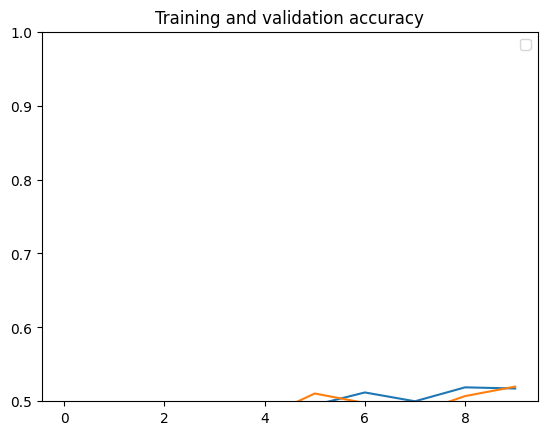

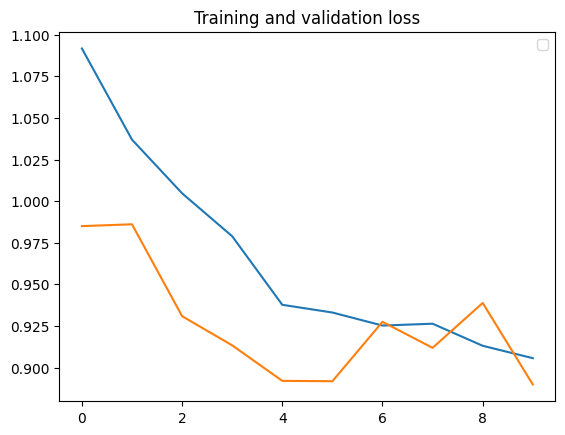

In [ ]:
# VISUALIZATION OF THE PROGRESS OF THE MODEL DURING THE TRAINING PROCESS
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]

loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs
# print(epochs)
# print(acc)
# print(val_acc)
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs,     val_acc )
plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.legend(loc='upper right')
plt.title ('Training and validation loss'   )

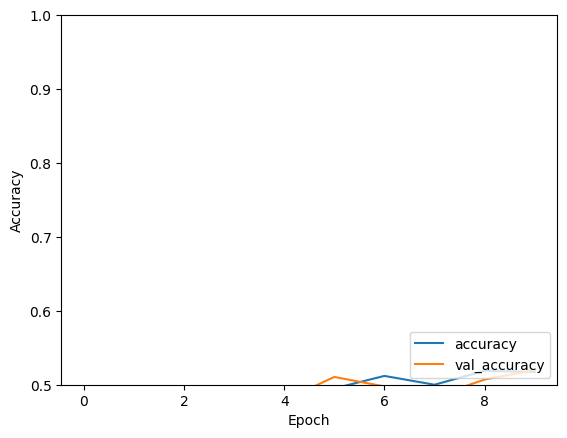

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

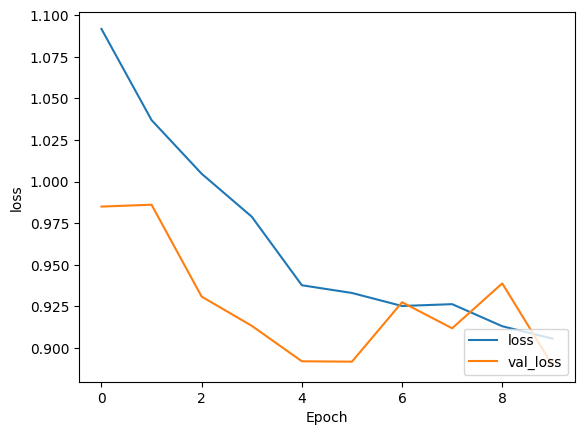

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

28/28 [==============================] - 13s 450ms/step
Confusion Matrix
[[19  4  6]
 [17  6  7]
 [31  9 12]]


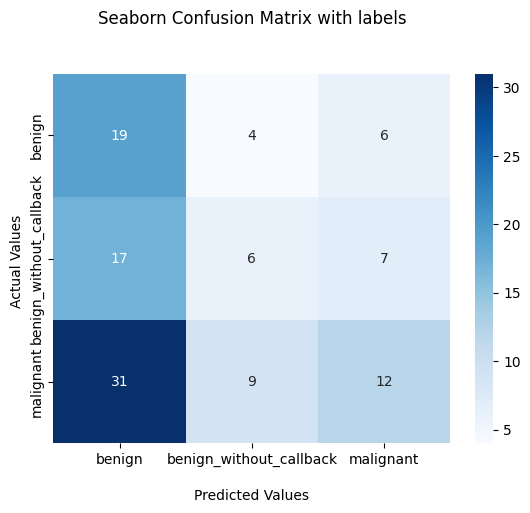

Classification Report
                         precision    recall  f1-score   support

                 benign       0.28      0.66      0.40        29
benign_without_callback       0.32      0.20      0.24        30
              malignant       0.48      0.23      0.31        52

               accuracy                           0.33       111
              macro avg       0.36      0.36      0.32       111
           weighted avg       0.38      0.33      0.32       111



In [ ]:
# ANALYSING THE PERFORMANNCE OF THE MODEL USING THE  THE CONFUSION MATRIX TABLE
# importing required dependencies.
import numpy as np
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

batch_size = 4
num_of_test_samples = 111

test_benign_dir = os.path.join(test_dir, 'benign')
test_malignant_dir = os.path.join(test_dir, 'malignant')
test_benign_without_callback_dir = os.path.join(test_dir, 'benign_without_callback')

#Confution Matrix and Classification Report
# validation_generator = validation_generator.reset()
Y_pred = model.predict(test_generator, num_of_test_samples // batch_size+1,  verbose = 'auto')
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

cf_matrix = confusion_matrix(test_generator.classes, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['benign','benign_without_callback', 'malignant'])
ax.yaxis.set_ticklabels(['benign','benign_without_callback', 'malignant'])

## Display the visualization of the Confusion Matrix.
plt.show()


# ----------ANALYSING THE CLASSIFICATION REPORT---------------------
print('Classification Report')
target_names = ['benign', 'benign_without_callback', 'malignant']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [ ]:
# saving the trained model to the specied path
# model.save("/content/model")

# creates a HDF5 file 'crop_weed_classifier_model.h5 and then saves it'
model.save('BreastCancerDetectorV0.01.h5')

In [ ]:
# converting the trained  model to tensorflowlite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# save the model
with open('BreastCancerDetectorV0.01.tflite', 'wb') as f:
  f.write(tflite_model)